📊 Analisis Sentimen Perubahan Iklim di Twitter
Capstone Project - IBM SkillBuilds

In [43]:
!pip install wordcloud scikit-learn matplotlib seaborn replicate

1. Import Libraries


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re, string

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# IBM Granite - Replicate
import replicate
import os

2. Load Dataset

In [45]:
import kagglehub

# Download data dari kaggle
path = kagglehub.dataset_download("edqian/twitter-climate-change-sentiment-dataset")

print("Path to dataset files:", path)

import os
import pandas as pd

# Cari semua file dalam folder
print("Isi folder:", os.listdir(path))

# ambil file .csv
csv_file = os.path.join(path, "twitter_sentiment_data.csv") # Corrected filename

# Baca ke DataFrame
df = pd.read_csv(csv_file)
print(df.head())

Path to dataset files: /kaggle/input/twitter-climate-change-sentiment-dataset
Isi folder: ['twitter_sentiment_data.csv']
   sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

              tweetid  
0  792927353886371840  
1  793124211518832641  
2  793124402388832256  
3  793124635873275904  
4  793125156185137153  


3. Preprocessing

In [46]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)          # hapus URL
    text = re.sub(r'@\w+', '', text)             # hapus mention
    text = re.sub(r'#\w+', '', text)             # hapus hashtag
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = re.sub(r'\d+', '', text)              # hapus angka
    text = text.strip()
    return text

df['clean_text'] = df['message'].apply(clean_text)

print("\nContoh teks sebelum dan sesudah cleaning:")
print(df[['message', 'clean_text']].head())


Contoh teks sebelum dan sesudah cleaning:
                                             message  \
0  @tiniebeany climate change is an interesting h...   
1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2  Fabulous! Leonardo #DiCaprio's film on #climat...   
3  RT @Mick_Fanning: Just watched this amazing do...   
4  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

                                          clean_text  
0  climate change is an interesting hustle as it ...  
1  rt  watch  right here as  travels the world to...  
2  fabulous leonardo s film on  change is brillia...  
3  rt  just watched this amazing documentary by l...  
4  rt  pranita biswasi a lutheran from odisha giv...  


4. Exploratory Data Analysis (EDA)

/tmp/ipython-input-3965056004.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette="viridis")


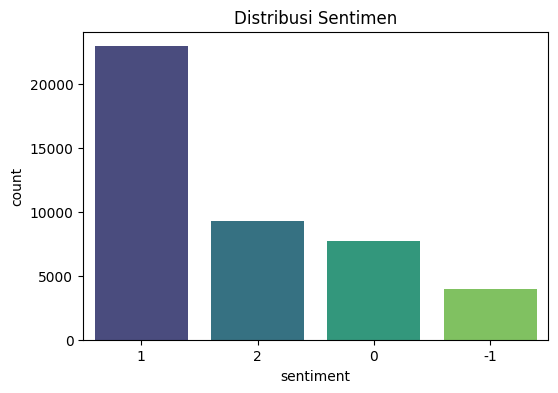

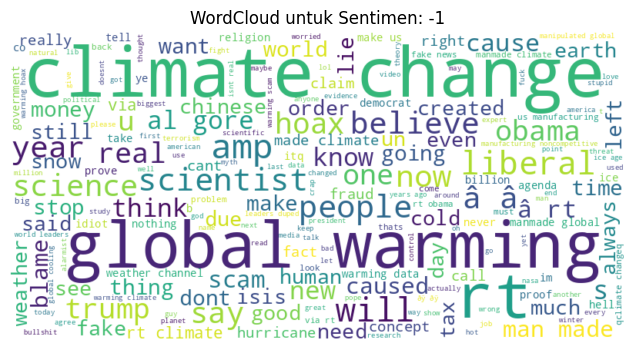

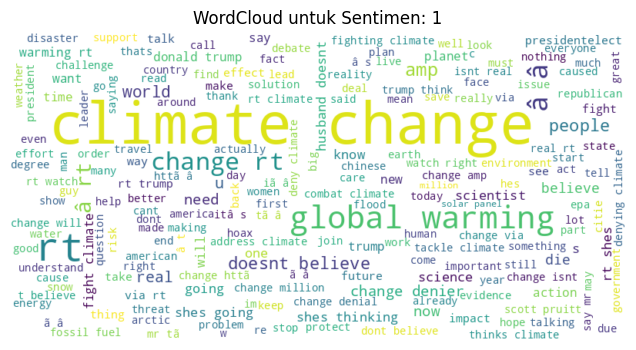

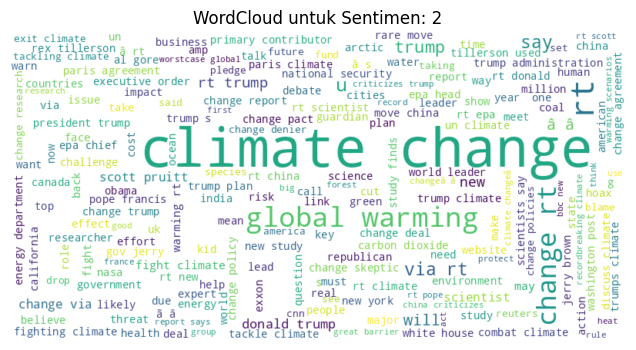

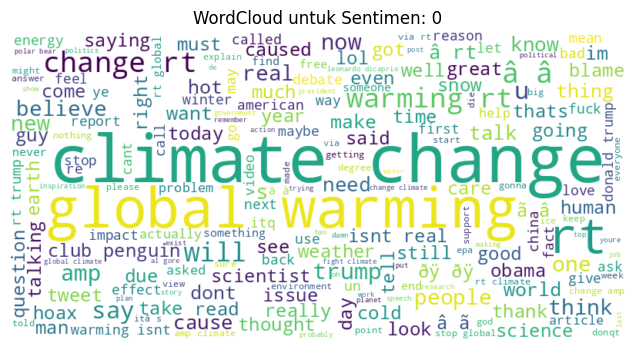

In [47]:
# Distribusi label
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette="viridis")
plt.title("Distribusi Sentimen")
plt.show()

# WordCloud untuk tiap sentimen
for label in df['sentiment'].unique():
    text = " ".join(df[df['sentiment']==label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk Sentimen: {label}")
    plt.show()

5. Preprocessing untuk ML

In [48]:
X = df['clean_text']
y = df['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorization (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print ("Preprocessing ML Selesai")

Preprocessing ML Selesai


6. Model Training & Evaluation

=== Naive Bayes Performance ===
              precision    recall  f1-score   support

          -1       0.75      0.23      0.35       798
           0       0.56      0.31      0.40      1543
           1       0.67      0.87      0.76      4593
           2       0.70      0.66      0.68      1855

    accuracy                           0.67      8789
   macro avg       0.67      0.52      0.55      8789
weighted avg       0.67      0.67      0.64      8789

=== Logistic Regression Performance ===
              precision    recall  f1-score   support

          -1       0.71      0.35      0.47       798
           0       0.58      0.40      0.47      1543
           1       0.72      0.87      0.79      4593
           2       0.73      0.72      0.72      1855

    accuracy                           0.71      8789
   macro avg       0.68      0.58      0.61      8789
weighted avg       0.70      0.71      0.69      8789



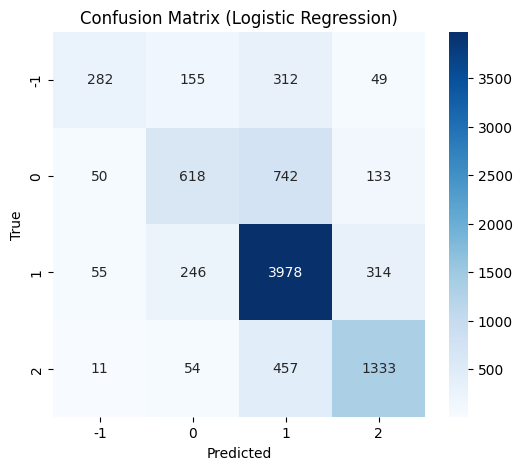

Logistic Regression Accuracy: 0.7066788030492661


In [49]:
# Model 1: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("=== Naive Bayes Performance ===")
print(classification_report(y_test, y_pred_nb))

# Model 2: Logistic Regression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print("=== Logistic Regression Performance ===")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Akurasi
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

7. Summarization Insight dengan IBM Granite (Replicate)

In [50]:
from google.colab import userdata
Token = userdata.get("API_TOKEN")
os.environ["REPLICATE_API_TOKEN"] = Token

model = replicate.models.get("ibm-granite/granite-3.3-8b-instruct")

def summarize_with_granite(text_list, sentiment_label):
    """Ringkas opini publik menggunakan IBM Granite via Replicate"""
    # Ambil 5 contoh text
    examples = "\n".join(text_list)
    prompt = f"Ringkas opini publik berikut terkait perubahan iklim (kategori: {sentiment_label}):\n{examples}\n"

    try:
        output = replicate.run(
            model,
            input={
                "prompt": prompt,
                "max_new_tokens": 150
            }
        )
        return "".join(output)
    except Exception as e:
        return f"Summarization gagal: {e}"

# Ambil contoh tweet untuk tiap label
pro_examples = df[df['sentiment']==1]['clean_text'].sample(min(5, len(df[df['sentiment']==1])), random_state=42).tolist()
anti_examples = df[df['sentiment']==-1]['clean_text'].sample(min(5, len(df[df['sentiment']==-1])), random_state=42).tolist()
neutral_examples = df[df['sentiment']==0]['clean_text'].sample(min(5, len(df[df['sentiment']==0])), random_state=42).tolist()
sentiment2_examples = df[df['sentiment']==2]['clean_text'].sample(min(5, len(df[df['sentiment']==2])), random_state=42).tolist()


print("\n=== Summarization Sentimen PRO ===")
print(summarize_with_granite(pro_examples, "PRO"))

print("\n=== Summarization Sentimen ANTI ===")
print(summarize_with_granite(anti_examples, "ANTI"))

print("\n=== Summarization Sentimen NETRAL ===")
print(summarize_with_granite(neutral_examples, "NETRAL"))

print("\n=== Summarization Sentimen POSITIVE NEWS (Label 2) ===")
print(summarize_with_granite(sentiment2_examples, "POSITIVE (Label 2)"))


=== Summarization Sentimen PRO ===
1. Public opinion is divided on climate change, with some expressing skepticism, such as the claim that global warming is a Chinese hoax to make US manufacturing non-competitive.

2. Conversely, there's strong support for climate change recognition, evident in reactions to the Weather Channel's stance against climate change denial outlets like Breitbart, affirming that climate change is real.

3. Despite national political disagreements, local officials are reportedly taking action on climate change, indicating grassroots acceptance and concern.

4. Some users criticize figures in power, like the incoming president, for not acknowledging climate change, implying widespread belief in its reality among the general public.

5. There's a general consensus that major oil companies, like Exxon, have been aware of global warming for decades, which may influence public perception and push for corporate accountability.

In summary, while some segments of publ

8. Insight & Recommendation

In [51]:
def generate_insight_and_recommendation(df, y_test, y_pred, model_name = "ibm-granite/granite-3.3-8b-instruct"):

    # Hitung distribusi label
    distribusi = df['sentiment'].value_counts(normalize=True).to_dict()

    # Ambil classification report ringkas
    from sklearn.metrics import classification_report
    report = classification_report(y_test, y_pred, output_dict=False)

    # Buat prompt untuk Granite
    prompt = f"""
    Berikut adalah hasil analisis sentimen terkait perubahan iklim:

    Distribusi Sentimen:
    {distribusi}

    Hasil Classification Report:
    {report}

    Berdasarkan data ini, buatlah:
    1. Insight & Findings utama tentang opini publik terkait perubahan iklim
    2. Rekomendasi strategis yang actionable untuk pemerintah/organisasi lingkungan
    3. Buatkanlah dalam bentuk poin-poin

    Jawab secara ringkas tapi padat dan menggunakan bahasa Indonesia.
    """

    try:
        output = replicate.run(
            model_name,
            input={
                "prompt": prompt,
                "max_new_tokens": 250
            }
        )
        return "".join(output)
    except Exception as e:
        return f"Gagal generate insight: {e}"

# Gunakan Logistic Regression prediction sebagai dasar insight
granite_insight = generate_insight_and_recommendation(df, y_test, y_pred_lr)

print("\n=== Insight & Recommendation (Granite) ===")
print(granite_insight)


=== Insight & Recommendation (Granite) ===
1. Insight & Findings utama tentang opini publik terkait perubahan iklim:

   - Sentimen negatif (score -1) terdapat sekitar 35% (798 data), menunjukkan ada sekitar 1/3 dari pendapat masyarakat yang tidak setuju atau bersikap skeptis terhadap perubahan iklim.
   - Sentimen netral (score 0) mencakup sekitar 17,55% (1543 data), mengindikasikan sekitar 1/6 pendapat masyarakat berada di titik tertentu tanpa lebih ke arah positif atau negatif.
   - Sentimen positif (score 1) paling banyak, sekitar 47% (4593 data), menunjukkan bahwa lebih dari 1/2 pendapat masyarakat menunjukkan dukungan atau setuju dengan isu perubahan iklim.
   - Sentimen positif terkuat (score 2) mencakup sekitar 12,25% (1855 data), menunjukkan ada sekitar 1/8 pendapat masyarakat yang sangat setuju atau berbangga dengan usaha-usaha untuk mengatasi perubahan iklim.

2. Rekomendasi strategis yang actionable untuk pemerintah/organisasi lingkungan:

   - **Mengurangi Sentimen Negati